# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.99KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

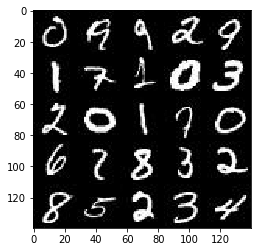

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

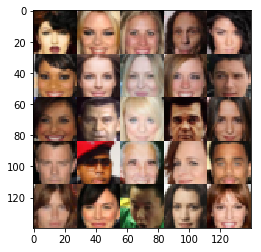

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(shape=[None,image_width,image_height,image_channels],dtype=tf.float32,name='input_real')
    inputs_z=tf.placeholder(shape=[None,z_dim],dtype=tf.float32,name='input_z')
    learning_rate=tf.placeholder(dtype=tf.float32,name='lr',shape=())
    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #conv1
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.maximum(x1,0.2*x1)
        x1=tf.nn.dropout(x1,0.8)
        #14*14*64
        
        #conv2
        x2=tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=True)
        x2=tf.maximum(x2,0.2*x2)
        x2=tf.nn.dropout(x2,0.8)
        #7*7*128
        
        #conv3
        x3=tf.layers.conv2d(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())#4*4*256
        logits=tf.layers.dense(tf.reshape(x3,(-1,4*4*256)),1) #fully-connected
        output=tf.nn.sigmoid(logits)
        
    return  output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse=not is_train
    with tf.variable_scope('generator',reuse=reuse):
        
        x1=tf.layers.dense(z,(7*7*512))
        x1=tf.reshape(x1,(-1,7,7,512))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(x1,0.2*x1)
        x1=tf.nn.dropout(x1,0.8)
        #7*7*512
        
        #conv1
        x2=tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(x2,0.2*x2)
        x2=tf.nn.dropout(x2,0.8)
        #14*14*256
        
        
        #conv2
        logits=tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        output=0.5*tf.tanh(logits)
        #28*28*out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim)
    d_real_output,d_real_logits=discriminator(input_real)
    d_fake_output,d_fake_logits=discriminator(g_model,True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_output)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_output)))
    d_loss=d_loss_real+d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_output)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    inputs_real,inputs_z,lr=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z,data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d,train_loss_g = d_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate}) ,g_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                    print("Epoch {}/{}...".format(steps, epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, inputs_z, data_shape[3], data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 10/0... Discriminator Loss: 8.4878... Generator Loss: 0.0012
Epoch 20/0... Discriminator Loss: 4.0990... Generator Loss: 0.0827
Epoch 30/0... Discriminator Loss: 2.7557... Generator Loss: 1.1737
Epoch 40/0... Discriminator Loss: 2.6760... Generator Loss: 0.2585
Epoch 50/0... Discriminator Loss: 2.6817... Generator Loss: 0.1998
Epoch 60/0... Discriminator Loss: 2.5631... Generator Loss: 0.2788
Epoch 70/0... Discriminator Loss: 2.1708... Generator Loss: 0.2851
Epoch 80/0... Discriminator Loss: 1.6789... Generator Loss: 0.7346
Epoch 90/0... Discriminator Loss: 1.7985... Generator Loss: 0.7442
Epoch 100/0... Discriminator Loss: 1.9500... Generator Loss: 0.4331


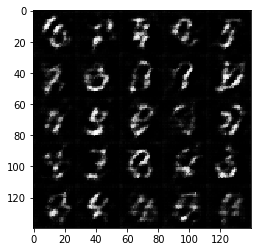

Epoch 110/0... Discriminator Loss: 1.8613... Generator Loss: 0.4067
Epoch 120/0... Discriminator Loss: 1.8729... Generator Loss: 0.4197
Epoch 130/0... Discriminator Loss: 1.7309... Generator Loss: 0.4723
Epoch 140/0... Discriminator Loss: 1.8192... Generator Loss: 0.4254
Epoch 150/0... Discriminator Loss: 1.8190... Generator Loss: 0.4038
Epoch 160/0... Discriminator Loss: 1.7261... Generator Loss: 0.6198
Epoch 170/0... Discriminator Loss: 1.5876... Generator Loss: 0.4954
Epoch 180/0... Discriminator Loss: 1.3710... Generator Loss: 0.7031
Epoch 190/0... Discriminator Loss: 1.4652... Generator Loss: 0.6681
Epoch 200/0... Discriminator Loss: 1.5080... Generator Loss: 0.6590


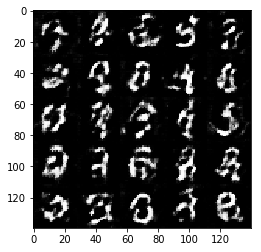

Epoch 210/0... Discriminator Loss: 1.4738... Generator Loss: 0.6367
Epoch 220/0... Discriminator Loss: 1.7984... Generator Loss: 0.3676
Epoch 230/0... Discriminator Loss: 1.8115... Generator Loss: 0.4928
Epoch 240/0... Discriminator Loss: 1.8778... Generator Loss: 0.4885
Epoch 250/0... Discriminator Loss: 1.5711... Generator Loss: 0.7671
Epoch 260/0... Discriminator Loss: 1.5450... Generator Loss: 0.7706
Epoch 270/0... Discriminator Loss: 1.6861... Generator Loss: 0.4886
Epoch 280/0... Discriminator Loss: 1.7075... Generator Loss: 0.6729
Epoch 290/0... Discriminator Loss: 1.3988... Generator Loss: 0.8814
Epoch 300/0... Discriminator Loss: 1.4230... Generator Loss: 0.6695


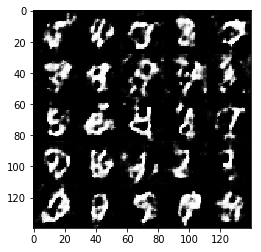

Epoch 310/0... Discriminator Loss: 1.3640... Generator Loss: 0.9250
Epoch 320/0... Discriminator Loss: 1.3946... Generator Loss: 0.5703
Epoch 330/0... Discriminator Loss: 1.5500... Generator Loss: 0.9610
Epoch 340/0... Discriminator Loss: 1.3494... Generator Loss: 0.6755
Epoch 350/0... Discriminator Loss: 1.3949... Generator Loss: 0.7777
Epoch 360/0... Discriminator Loss: 1.3356... Generator Loss: 0.7584
Epoch 370/0... Discriminator Loss: 1.5446... Generator Loss: 0.7177
Epoch 380/0... Discriminator Loss: 1.6143... Generator Loss: 0.4955
Epoch 390/0... Discriminator Loss: 1.2950... Generator Loss: 1.0632
Epoch 400/0... Discriminator Loss: 1.4547... Generator Loss: 0.6091


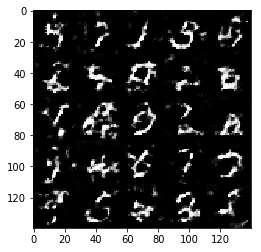

Epoch 410/0... Discriminator Loss: 1.6408... Generator Loss: 0.6518
Epoch 420/0... Discriminator Loss: 1.7158... Generator Loss: 0.4443
Epoch 430/0... Discriminator Loss: 1.5652... Generator Loss: 0.5826
Epoch 440/0... Discriminator Loss: 1.3557... Generator Loss: 0.6665
Epoch 450/0... Discriminator Loss: 1.5501... Generator Loss: 0.5937
Epoch 460/0... Discriminator Loss: 1.5110... Generator Loss: 0.6626
Epoch 470/0... Discriminator Loss: 1.5696... Generator Loss: 0.8396
Epoch 480/0... Discriminator Loss: 1.4730... Generator Loss: 0.5097
Epoch 490/0... Discriminator Loss: 1.5416... Generator Loss: 0.6667
Epoch 500/0... Discriminator Loss: 1.6513... Generator Loss: 0.3753


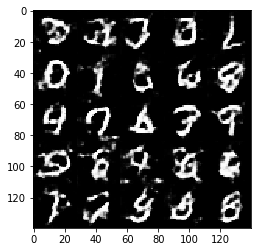

Epoch 510/0... Discriminator Loss: 1.2921... Generator Loss: 0.7812
Epoch 520/0... Discriminator Loss: 1.6306... Generator Loss: 0.6360
Epoch 530/0... Discriminator Loss: 2.0489... Generator Loss: 0.2620
Epoch 540/0... Discriminator Loss: 1.5852... Generator Loss: 0.4988
Epoch 550/0... Discriminator Loss: 1.3526... Generator Loss: 0.8508
Epoch 560/0... Discriminator Loss: 1.4705... Generator Loss: 0.5778
Epoch 570/0... Discriminator Loss: 1.3656... Generator Loss: 0.7030
Epoch 580/0... Discriminator Loss: 1.4027... Generator Loss: 0.7905
Epoch 590/0... Discriminator Loss: 1.5913... Generator Loss: 0.6842
Epoch 600/0... Discriminator Loss: 1.5318... Generator Loss: 0.6199


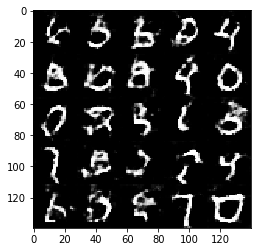

Epoch 610/0... Discriminator Loss: 1.4591... Generator Loss: 0.6742
Epoch 620/0... Discriminator Loss: 1.5781... Generator Loss: 0.5525
Epoch 630/0... Discriminator Loss: 1.5592... Generator Loss: 0.4530
Epoch 640/0... Discriminator Loss: 1.5263... Generator Loss: 0.7001
Epoch 650/0... Discriminator Loss: 1.5325... Generator Loss: 0.6154
Epoch 660/0... Discriminator Loss: 1.5157... Generator Loss: 0.8051
Epoch 670/0... Discriminator Loss: 1.5713... Generator Loss: 0.6706
Epoch 680/0... Discriminator Loss: 1.4844... Generator Loss: 0.5441
Epoch 690/0... Discriminator Loss: 1.4037... Generator Loss: 0.9465
Epoch 700/0... Discriminator Loss: 1.3951... Generator Loss: 0.8930


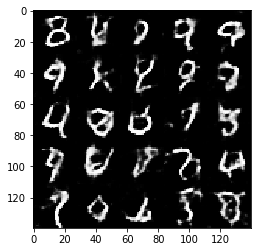

Epoch 710/0... Discriminator Loss: 1.5374... Generator Loss: 0.4495
Epoch 720/0... Discriminator Loss: 1.3072... Generator Loss: 1.0165
Epoch 730/0... Discriminator Loss: 1.4643... Generator Loss: 0.7443
Epoch 740/0... Discriminator Loss: 1.4982... Generator Loss: 0.9337
Epoch 750/0... Discriminator Loss: 1.3909... Generator Loss: 0.6509
Epoch 760/0... Discriminator Loss: 1.4378... Generator Loss: 0.8001
Epoch 770/0... Discriminator Loss: 1.6457... Generator Loss: 0.6676
Epoch 780/0... Discriminator Loss: 1.4178... Generator Loss: 0.7278
Epoch 790/0... Discriminator Loss: 1.2531... Generator Loss: 0.7284
Epoch 800/0... Discriminator Loss: 1.3726... Generator Loss: 0.9766


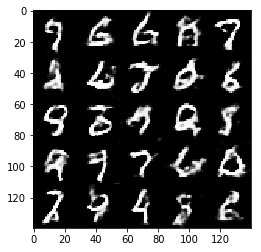

Epoch 810/0... Discriminator Loss: 1.6611... Generator Loss: 0.4869
Epoch 820/0... Discriminator Loss: 1.5210... Generator Loss: 0.7774
Epoch 830/0... Discriminator Loss: 1.4706... Generator Loss: 0.5691
Epoch 840/0... Discriminator Loss: 1.3303... Generator Loss: 0.8855
Epoch 850/0... Discriminator Loss: 1.3804... Generator Loss: 0.6359
Epoch 860/0... Discriminator Loss: 1.9503... Generator Loss: 0.2657
Epoch 870/0... Discriminator Loss: 1.3496... Generator Loss: 0.8535
Epoch 880/0... Discriminator Loss: 1.3686... Generator Loss: 0.6803
Epoch 890/0... Discriminator Loss: 1.4325... Generator Loss: 0.7557
Epoch 900/0... Discriminator Loss: 1.4686... Generator Loss: 0.5510


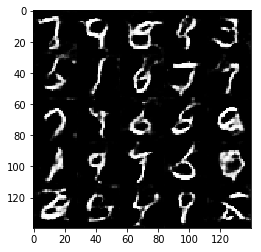

Epoch 910/0... Discriminator Loss: 1.5253... Generator Loss: 0.5496
Epoch 920/0... Discriminator Loss: 1.3738... Generator Loss: 0.6140
Epoch 930/0... Discriminator Loss: 1.5507... Generator Loss: 0.6432
Epoch 940/0... Discriminator Loss: 1.3711... Generator Loss: 0.7096
Epoch 950/0... Discriminator Loss: 1.3964... Generator Loss: 0.7947
Epoch 960/0... Discriminator Loss: 1.7293... Generator Loss: 1.6208
Epoch 970/0... Discriminator Loss: 1.4268... Generator Loss: 0.8991
Epoch 980/0... Discriminator Loss: 1.3790... Generator Loss: 0.8039
Epoch 990/0... Discriminator Loss: 1.5623... Generator Loss: 0.4847
Epoch 1000/0... Discriminator Loss: 1.4980... Generator Loss: 1.0266


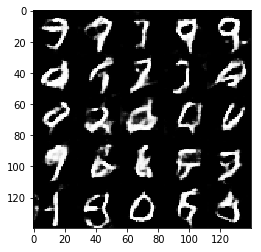

Epoch 1010/0... Discriminator Loss: 1.3137... Generator Loss: 0.7804
Epoch 1020/0... Discriminator Loss: 1.4445... Generator Loss: 0.6358
Epoch 1030/0... Discriminator Loss: 1.5296... Generator Loss: 0.5647
Epoch 1040/0... Discriminator Loss: 1.4657... Generator Loss: 0.5067
Epoch 1050/0... Discriminator Loss: 1.4440... Generator Loss: 0.7380
Epoch 1060/0... Discriminator Loss: 1.5691... Generator Loss: 0.6038
Epoch 1070/0... Discriminator Loss: 1.2170... Generator Loss: 1.0677
Epoch 1080/0... Discriminator Loss: 1.4779... Generator Loss: 0.9063
Epoch 1090/0... Discriminator Loss: 1.5048... Generator Loss: 0.5324
Epoch 1100/0... Discriminator Loss: 1.3652... Generator Loss: 0.7782


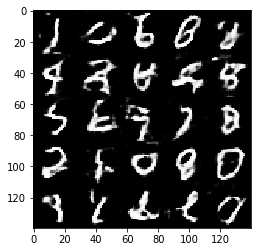

Epoch 1110/0... Discriminator Loss: 1.4577... Generator Loss: 0.6836
Epoch 1120/0... Discriminator Loss: 1.5369... Generator Loss: 0.7125
Epoch 1130/0... Discriminator Loss: 1.2300... Generator Loss: 0.8430
Epoch 1140/0... Discriminator Loss: 1.4502... Generator Loss: 0.9354
Epoch 1150/0... Discriminator Loss: 1.2088... Generator Loss: 0.8085
Epoch 1160/0... Discriminator Loss: 1.4451... Generator Loss: 1.0542
Epoch 1170/0... Discriminator Loss: 1.4490... Generator Loss: 0.5269
Epoch 1180/0... Discriminator Loss: 1.4465... Generator Loss: 0.7008
Epoch 1190/0... Discriminator Loss: 1.2126... Generator Loss: 0.8987
Epoch 1200/0... Discriminator Loss: 1.6127... Generator Loss: 0.4364


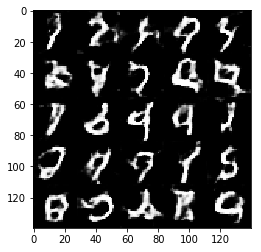

Epoch 1210/0... Discriminator Loss: 1.3323... Generator Loss: 0.9947
Epoch 1220/0... Discriminator Loss: 1.2813... Generator Loss: 0.7927
Epoch 1230/0... Discriminator Loss: 1.5052... Generator Loss: 1.2264
Epoch 1240/0... Discriminator Loss: 1.4095... Generator Loss: 0.7775
Epoch 1250/0... Discriminator Loss: 1.4231... Generator Loss: 0.6025
Epoch 1260/0... Discriminator Loss: 1.1864... Generator Loss: 1.0189
Epoch 1270/0... Discriminator Loss: 1.3630... Generator Loss: 0.5334
Epoch 1280/0... Discriminator Loss: 1.4202... Generator Loss: 1.1067
Epoch 1290/0... Discriminator Loss: 1.4357... Generator Loss: 0.5947
Epoch 1300/0... Discriminator Loss: 1.5122... Generator Loss: 1.0719


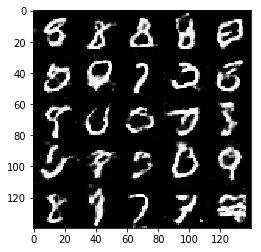

Epoch 1310/0... Discriminator Loss: 1.8048... Generator Loss: 0.3200
Epoch 1320/0... Discriminator Loss: 1.3574... Generator Loss: 0.7884
Epoch 1330/0... Discriminator Loss: 2.1402... Generator Loss: 0.2375
Epoch 1340/0... Discriminator Loss: 1.3024... Generator Loss: 1.0674
Epoch 1350/0... Discriminator Loss: 1.4435... Generator Loss: 0.6035
Epoch 1360/0... Discriminator Loss: 1.3966... Generator Loss: 0.9017
Epoch 1370/0... Discriminator Loss: 1.3967... Generator Loss: 0.6882
Epoch 1380/0... Discriminator Loss: 1.7443... Generator Loss: 0.3866
Epoch 1390/0... Discriminator Loss: 1.5601... Generator Loss: 0.5108
Epoch 1400/0... Discriminator Loss: 1.4030... Generator Loss: 0.8535


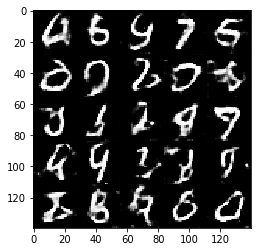

Epoch 1410/0... Discriminator Loss: 1.3613... Generator Loss: 0.5716
Epoch 1420/0... Discriminator Loss: 1.2337... Generator Loss: 0.8117
Epoch 1430/0... Discriminator Loss: 1.3232... Generator Loss: 0.8105
Epoch 1440/0... Discriminator Loss: 1.6085... Generator Loss: 0.5833
Epoch 1450/0... Discriminator Loss: 1.3713... Generator Loss: 0.9557
Epoch 1460/0... Discriminator Loss: 1.3419... Generator Loss: 0.7428
Epoch 1470/0... Discriminator Loss: 1.3586... Generator Loss: 0.7006
Epoch 1480/0... Discriminator Loss: 1.4002... Generator Loss: 0.6979
Epoch 1490/0... Discriminator Loss: 1.2506... Generator Loss: 0.7914
Epoch 1500/0... Discriminator Loss: 1.3709... Generator Loss: 0.6044


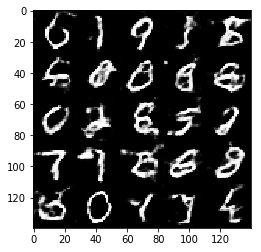

Epoch 1510/0... Discriminator Loss: 1.4343... Generator Loss: 0.7397
Epoch 1520/0... Discriminator Loss: 1.8557... Generator Loss: 1.7981
Epoch 1530/0... Discriminator Loss: 1.3274... Generator Loss: 0.7273
Epoch 1540/0... Discriminator Loss: 1.2970... Generator Loss: 0.8236
Epoch 1550/0... Discriminator Loss: 1.4295... Generator Loss: 0.5037
Epoch 1560/0... Discriminator Loss: 1.5428... Generator Loss: 0.8677
Epoch 1570/0... Discriminator Loss: 1.4427... Generator Loss: 0.7099
Epoch 1580/0... Discriminator Loss: 1.3907... Generator Loss: 0.7298
Epoch 1590/0... Discriminator Loss: 1.5710... Generator Loss: 0.8687
Epoch 1600/0... Discriminator Loss: 2.2126... Generator Loss: 0.2074


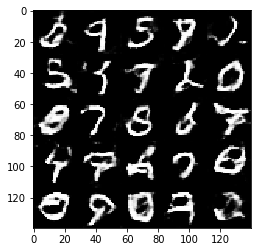

Epoch 1610/0... Discriminator Loss: 1.2257... Generator Loss: 0.6959
Epoch 1620/0... Discriminator Loss: 1.8743... Generator Loss: 2.3431
Epoch 1630/0... Discriminator Loss: 1.4050... Generator Loss: 0.7174
Epoch 1640/0... Discriminator Loss: 1.3563... Generator Loss: 0.8022
Epoch 1650/0... Discriminator Loss: 1.2772... Generator Loss: 0.8750
Epoch 1660/0... Discriminator Loss: 1.3253... Generator Loss: 1.3362
Epoch 1670/0... Discriminator Loss: 1.4180... Generator Loss: 0.6785
Epoch 1680/0... Discriminator Loss: 1.4477... Generator Loss: 0.5951
Epoch 1690/0... Discriminator Loss: 1.4525... Generator Loss: 0.5810
Epoch 1700/0... Discriminator Loss: 1.3064... Generator Loss: 0.7851


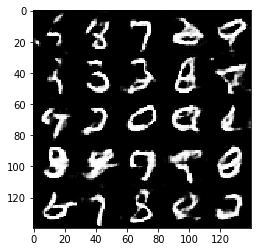

Epoch 1710/0... Discriminator Loss: 1.2364... Generator Loss: 1.0253
Epoch 1720/0... Discriminator Loss: 1.3122... Generator Loss: 1.0320
Epoch 1730/0... Discriminator Loss: 1.7430... Generator Loss: 0.3184
Epoch 1740/0... Discriminator Loss: 1.2582... Generator Loss: 0.9704
Epoch 1750/0... Discriminator Loss: 1.4015... Generator Loss: 0.5205
Epoch 1760/0... Discriminator Loss: 1.6061... Generator Loss: 0.4898
Epoch 1770/0... Discriminator Loss: 1.3310... Generator Loss: 1.1148
Epoch 1780/0... Discriminator Loss: 1.3651... Generator Loss: 1.0655
Epoch 1790/0... Discriminator Loss: 1.2265... Generator Loss: 1.0266
Epoch 1800/0... Discriminator Loss: 1.1930... Generator Loss: 0.7718


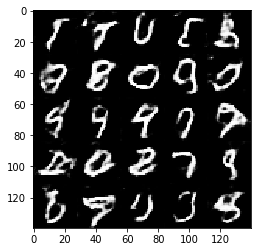

Epoch 1810/0... Discriminator Loss: 1.5568... Generator Loss: 0.6179
Epoch 1820/0... Discriminator Loss: 1.4638... Generator Loss: 0.5795
Epoch 1830/0... Discriminator Loss: 1.4336... Generator Loss: 0.7503
Epoch 1840/0... Discriminator Loss: 1.3899... Generator Loss: 0.9196
Epoch 1850/0... Discriminator Loss: 1.3376... Generator Loss: 0.7319
Epoch 1860/0... Discriminator Loss: 1.3685... Generator Loss: 0.7894
Epoch 1870/0... Discriminator Loss: 1.3517... Generator Loss: 1.9095
Epoch 1880/1... Discriminator Loss: 1.2326... Generator Loss: 1.1827
Epoch 1890/1... Discriminator Loss: 1.6102... Generator Loss: 0.4823
Epoch 1900/1... Discriminator Loss: 1.3101... Generator Loss: 1.0850


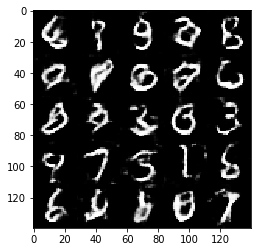

Epoch 1910/1... Discriminator Loss: 1.1697... Generator Loss: 0.9937
Epoch 1920/1... Discriminator Loss: 1.3496... Generator Loss: 0.9279
Epoch 1930/1... Discriminator Loss: 1.2272... Generator Loss: 0.9442
Epoch 1940/1... Discriminator Loss: 1.2202... Generator Loss: 0.6624
Epoch 1950/1... Discriminator Loss: 1.4307... Generator Loss: 1.0979
Epoch 1960/1... Discriminator Loss: 1.5894... Generator Loss: 1.9043
Epoch 1970/1... Discriminator Loss: 1.3124... Generator Loss: 0.8342
Epoch 1980/1... Discriminator Loss: 1.3299... Generator Loss: 0.8270
Epoch 1990/1... Discriminator Loss: 1.2398... Generator Loss: 0.7689
Epoch 2000/1... Discriminator Loss: 1.5195... Generator Loss: 0.7750


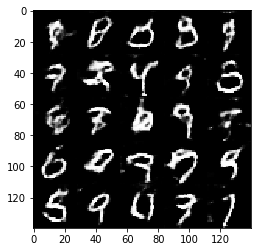

Epoch 2010/1... Discriminator Loss: 1.6224... Generator Loss: 0.3755
Epoch 2020/1... Discriminator Loss: 1.4074... Generator Loss: 1.3623
Epoch 2030/1... Discriminator Loss: 1.2494... Generator Loss: 1.1396
Epoch 2040/1... Discriminator Loss: 1.3694... Generator Loss: 0.7329
Epoch 2050/1... Discriminator Loss: 1.2621... Generator Loss: 0.6084
Epoch 2060/1... Discriminator Loss: 1.3296... Generator Loss: 0.8427
Epoch 2070/1... Discriminator Loss: 2.2389... Generator Loss: 0.3015
Epoch 2080/1... Discriminator Loss: 1.4838... Generator Loss: 0.5048
Epoch 2090/1... Discriminator Loss: 1.3720... Generator Loss: 0.7671
Epoch 2100/1... Discriminator Loss: 1.1420... Generator Loss: 1.0640


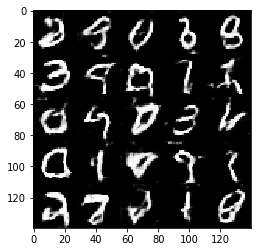

Epoch 2110/1... Discriminator Loss: 1.1830... Generator Loss: 1.1597
Epoch 2120/1... Discriminator Loss: 1.2048... Generator Loss: 0.8773
Epoch 2130/1... Discriminator Loss: 1.3594... Generator Loss: 0.8089
Epoch 2140/1... Discriminator Loss: 1.6806... Generator Loss: 1.6150
Epoch 2150/1... Discriminator Loss: 1.3931... Generator Loss: 0.6693
Epoch 2160/1... Discriminator Loss: 1.4103... Generator Loss: 0.5944
Epoch 2170/1... Discriminator Loss: 1.2730... Generator Loss: 0.8915
Epoch 2180/1... Discriminator Loss: 1.3776... Generator Loss: 0.6231
Epoch 2190/1... Discriminator Loss: 1.3308... Generator Loss: 0.6984
Epoch 2200/1... Discriminator Loss: 1.1675... Generator Loss: 0.8286


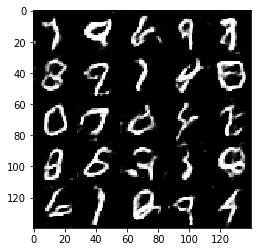

Epoch 2210/1... Discriminator Loss: 1.6548... Generator Loss: 1.7248
Epoch 2220/1... Discriminator Loss: 1.4424... Generator Loss: 0.9243
Epoch 2230/1... Discriminator Loss: 1.3769... Generator Loss: 1.0196
Epoch 2240/1... Discriminator Loss: 1.2858... Generator Loss: 1.1507
Epoch 2250/1... Discriminator Loss: 1.2511... Generator Loss: 1.0162
Epoch 2260/1... Discriminator Loss: 1.4038... Generator Loss: 1.3913
Epoch 2270/1... Discriminator Loss: 1.3211... Generator Loss: 0.8520
Epoch 2280/1... Discriminator Loss: 1.2104... Generator Loss: 1.1183
Epoch 2290/1... Discriminator Loss: 1.2683... Generator Loss: 0.7929
Epoch 2300/1... Discriminator Loss: 1.5544... Generator Loss: 1.8556


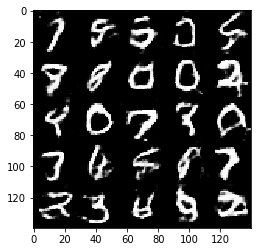

Epoch 2310/1... Discriminator Loss: 1.1069... Generator Loss: 0.9631
Epoch 2320/1... Discriminator Loss: 1.1988... Generator Loss: 1.2495
Epoch 2330/1... Discriminator Loss: 1.3327... Generator Loss: 0.8736
Epoch 2340/1... Discriminator Loss: 1.1223... Generator Loss: 1.0306
Epoch 2350/1... Discriminator Loss: 1.4618... Generator Loss: 0.7302
Epoch 2360/1... Discriminator Loss: 1.2571... Generator Loss: 0.9608
Epoch 2370/1... Discriminator Loss: 1.4079... Generator Loss: 0.6791
Epoch 2380/1... Discriminator Loss: 1.7048... Generator Loss: 0.7276
Epoch 2390/1... Discriminator Loss: 1.0029... Generator Loss: 1.1976
Epoch 2400/1... Discriminator Loss: 1.0489... Generator Loss: 1.2455


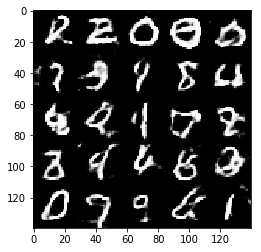

Epoch 2410/1... Discriminator Loss: 2.1206... Generator Loss: 0.2848
Epoch 2420/1... Discriminator Loss: 1.2169... Generator Loss: 1.1399
Epoch 2430/1... Discriminator Loss: 1.3371... Generator Loss: 0.8812
Epoch 2440/1... Discriminator Loss: 1.3817... Generator Loss: 1.6976
Epoch 2450/1... Discriminator Loss: 1.3096... Generator Loss: 0.9825
Epoch 2460/1... Discriminator Loss: 1.4805... Generator Loss: 1.3223
Epoch 2470/1... Discriminator Loss: 1.3163... Generator Loss: 0.7211
Epoch 2480/1... Discriminator Loss: 1.1936... Generator Loss: 0.8695
Epoch 2490/1... Discriminator Loss: 1.1608... Generator Loss: 0.8822
Epoch 2500/1... Discriminator Loss: 1.4848... Generator Loss: 1.6231


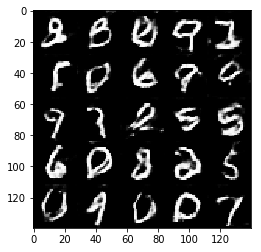

Epoch 2510/1... Discriminator Loss: 1.3922... Generator Loss: 0.6471
Epoch 2520/1... Discriminator Loss: 1.1356... Generator Loss: 2.0797
Epoch 2530/1... Discriminator Loss: 1.1222... Generator Loss: 0.7519
Epoch 2540/1... Discriminator Loss: 1.3802... Generator Loss: 1.2292
Epoch 2550/1... Discriminator Loss: 1.1432... Generator Loss: 0.9680
Epoch 2560/1... Discriminator Loss: 1.4492... Generator Loss: 1.4877
Epoch 2570/1... Discriminator Loss: 1.1787... Generator Loss: 0.8630
Epoch 2580/1... Discriminator Loss: 1.2586... Generator Loss: 0.7092
Epoch 2590/1... Discriminator Loss: 1.4340... Generator Loss: 0.6925
Epoch 2600/1... Discriminator Loss: 1.2851... Generator Loss: 0.7590


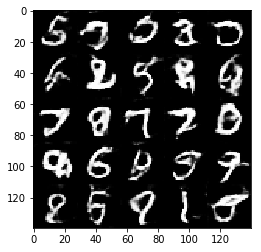

Epoch 2610/1... Discriminator Loss: 1.4145... Generator Loss: 0.7487
Epoch 2620/1... Discriminator Loss: 1.1528... Generator Loss: 1.2839
Epoch 2630/1... Discriminator Loss: 1.1661... Generator Loss: 0.7526
Epoch 2640/1... Discriminator Loss: 1.4115... Generator Loss: 1.1740
Epoch 2650/1... Discriminator Loss: 1.3351... Generator Loss: 0.8121
Epoch 2660/1... Discriminator Loss: 1.5461... Generator Loss: 0.5196
Epoch 2670/1... Discriminator Loss: 1.3830... Generator Loss: 0.7157
Epoch 2680/1... Discriminator Loss: 1.2191... Generator Loss: 0.8436
Epoch 2690/1... Discriminator Loss: 1.2593... Generator Loss: 0.6408
Epoch 2700/1... Discriminator Loss: 1.2825... Generator Loss: 0.9502


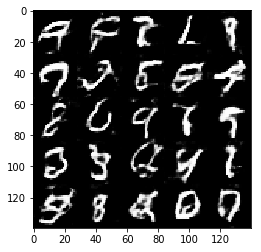

Epoch 2710/1... Discriminator Loss: 1.3642... Generator Loss: 1.3225
Epoch 2720/1... Discriminator Loss: 1.0200... Generator Loss: 0.9509
Epoch 2730/1... Discriminator Loss: 1.1890... Generator Loss: 1.5995
Epoch 2740/1... Discriminator Loss: 1.3510... Generator Loss: 0.7700
Epoch 2750/1... Discriminator Loss: 1.2662... Generator Loss: 0.9006
Epoch 2760/1... Discriminator Loss: 1.1139... Generator Loss: 0.8188
Epoch 2770/1... Discriminator Loss: 1.2101... Generator Loss: 1.1749
Epoch 2780/1... Discriminator Loss: 1.5739... Generator Loss: 1.4783
Epoch 2790/1... Discriminator Loss: 1.2786... Generator Loss: 1.0321
Epoch 2800/1... Discriminator Loss: 1.2838... Generator Loss: 0.7981


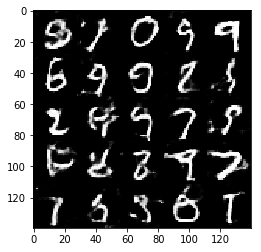

Epoch 2810/1... Discriminator Loss: 1.5505... Generator Loss: 0.5991
Epoch 2820/1... Discriminator Loss: 1.4500... Generator Loss: 0.6806
Epoch 2830/1... Discriminator Loss: 1.1402... Generator Loss: 0.9762
Epoch 2840/1... Discriminator Loss: 1.5582... Generator Loss: 0.4148
Epoch 2850/1... Discriminator Loss: 1.2313... Generator Loss: 0.9908
Epoch 2860/1... Discriminator Loss: 1.3381... Generator Loss: 0.8997
Epoch 2870/1... Discriminator Loss: 0.9821... Generator Loss: 0.9832
Epoch 2880/1... Discriminator Loss: 1.2721... Generator Loss: 0.8326
Epoch 2890/1... Discriminator Loss: 1.1194... Generator Loss: 1.1698
Epoch 2900/1... Discriminator Loss: 1.2445... Generator Loss: 0.7995


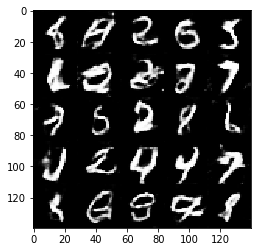

Epoch 2910/1... Discriminator Loss: 1.2018... Generator Loss: 1.0819
Epoch 2920/1... Discriminator Loss: 1.1223... Generator Loss: 1.3089
Epoch 2930/1... Discriminator Loss: 1.1974... Generator Loss: 1.3495
Epoch 2940/1... Discriminator Loss: 1.2376... Generator Loss: 1.0234
Epoch 2950/1... Discriminator Loss: 1.3586... Generator Loss: 0.6849
Epoch 2960/1... Discriminator Loss: 1.3248... Generator Loss: 2.0930
Epoch 2970/1... Discriminator Loss: 1.0256... Generator Loss: 1.3595
Epoch 2980/1... Discriminator Loss: 1.7224... Generator Loss: 0.6343
Epoch 2990/1... Discriminator Loss: 0.9638... Generator Loss: 1.2142
Epoch 3000/1... Discriminator Loss: 1.1314... Generator Loss: 1.2638


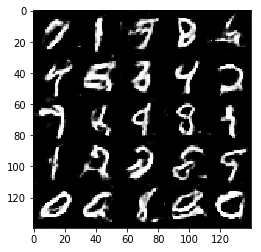

Epoch 3010/1... Discriminator Loss: 1.1543... Generator Loss: 1.2819
Epoch 3020/1... Discriminator Loss: 1.2411... Generator Loss: 0.9527
Epoch 3030/1... Discriminator Loss: 1.5457... Generator Loss: 1.7651
Epoch 3040/1... Discriminator Loss: 1.1489... Generator Loss: 0.9922
Epoch 3050/1... Discriminator Loss: 1.1825... Generator Loss: 1.1062
Epoch 3060/1... Discriminator Loss: 1.1892... Generator Loss: 1.5240
Epoch 3070/1... Discriminator Loss: 1.1176... Generator Loss: 1.2264
Epoch 3080/1... Discriminator Loss: 1.1620... Generator Loss: 1.7572
Epoch 3090/1... Discriminator Loss: 1.3389... Generator Loss: 0.8157
Epoch 3100/1... Discriminator Loss: 1.5026... Generator Loss: 0.8762


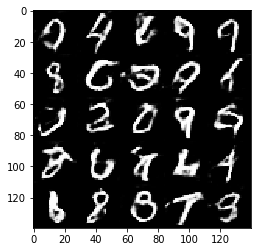

Epoch 3110/1... Discriminator Loss: 1.2274... Generator Loss: 0.6760
Epoch 3120/1... Discriminator Loss: 1.3519... Generator Loss: 0.5840
Epoch 3130/1... Discriminator Loss: 1.1023... Generator Loss: 1.1855
Epoch 3140/1... Discriminator Loss: 1.3214... Generator Loss: 0.7125
Epoch 3150/1... Discriminator Loss: 1.9653... Generator Loss: 0.3626
Epoch 3160/1... Discriminator Loss: 1.2639... Generator Loss: 1.0915
Epoch 3170/1... Discriminator Loss: 1.2448... Generator Loss: 0.7269
Epoch 3180/1... Discriminator Loss: 1.2177... Generator Loss: 1.4636
Epoch 3190/1... Discriminator Loss: 1.2654... Generator Loss: 1.0755
Epoch 3200/1... Discriminator Loss: 1.1919... Generator Loss: 0.8568


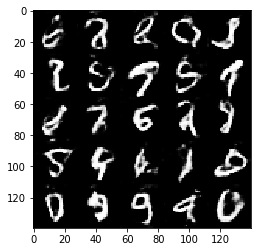

Epoch 3210/1... Discriminator Loss: 1.4021... Generator Loss: 0.7439
Epoch 3220/1... Discriminator Loss: 1.0151... Generator Loss: 0.9854
Epoch 3230/1... Discriminator Loss: 1.0514... Generator Loss: 1.0331
Epoch 3240/1... Discriminator Loss: 1.3174... Generator Loss: 1.2655
Epoch 3250/1... Discriminator Loss: 2.2614... Generator Loss: 0.4082
Epoch 3260/1... Discriminator Loss: 1.0244... Generator Loss: 1.4289
Epoch 3270/1... Discriminator Loss: 1.0723... Generator Loss: 1.7435
Epoch 3280/1... Discriminator Loss: 1.0422... Generator Loss: 0.8936
Epoch 3290/1... Discriminator Loss: 1.4284... Generator Loss: 0.8017
Epoch 3300/1... Discriminator Loss: 1.2032... Generator Loss: 0.7310


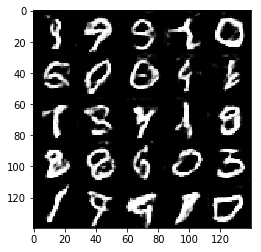

Epoch 3310/1... Discriminator Loss: 1.5642... Generator Loss: 0.5770
Epoch 3320/1... Discriminator Loss: 1.0796... Generator Loss: 0.9461
Epoch 3330/1... Discriminator Loss: 1.1022... Generator Loss: 0.9106
Epoch 3340/1... Discriminator Loss: 1.1034... Generator Loss: 1.3573
Epoch 3350/1... Discriminator Loss: 1.0409... Generator Loss: 1.2782
Epoch 3360/1... Discriminator Loss: 1.0737... Generator Loss: 1.6778
Epoch 3370/1... Discriminator Loss: 0.9906... Generator Loss: 1.1008
Epoch 3380/1... Discriminator Loss: 1.3029... Generator Loss: 1.3882
Epoch 3390/1... Discriminator Loss: 1.5434... Generator Loss: 0.9721
Epoch 3400/1... Discriminator Loss: 1.5057... Generator Loss: 0.6567


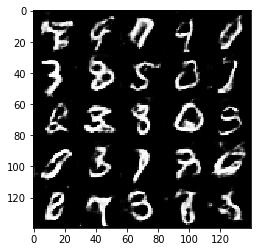

Epoch 3410/1... Discriminator Loss: 1.2569... Generator Loss: 1.1282
Epoch 3420/1... Discriminator Loss: 1.4393... Generator Loss: 1.3873
Epoch 3430/1... Discriminator Loss: 1.3984... Generator Loss: 0.8104
Epoch 3440/1... Discriminator Loss: 1.7109... Generator Loss: 0.3425
Epoch 3450/1... Discriminator Loss: 1.5401... Generator Loss: 0.7591
Epoch 3460/1... Discriminator Loss: 1.2221... Generator Loss: 1.9178
Epoch 3470/1... Discriminator Loss: 1.1069... Generator Loss: 1.6634
Epoch 3480/1... Discriminator Loss: 1.2342... Generator Loss: 1.6783
Epoch 3490/1... Discriminator Loss: 1.0772... Generator Loss: 1.1970
Epoch 3500/1... Discriminator Loss: 1.2529... Generator Loss: 1.0422


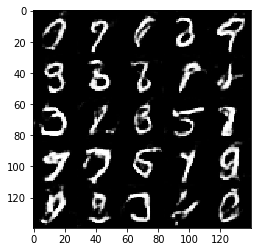

Epoch 3510/1... Discriminator Loss: 0.9654... Generator Loss: 0.8667
Epoch 3520/1... Discriminator Loss: 1.3485... Generator Loss: 0.7118
Epoch 3530/1... Discriminator Loss: 1.0989... Generator Loss: 1.1896
Epoch 3540/1... Discriminator Loss: 1.1607... Generator Loss: 1.4543
Epoch 3550/1... Discriminator Loss: 1.2521... Generator Loss: 0.9081
Epoch 3560/1... Discriminator Loss: 1.0571... Generator Loss: 1.4867
Epoch 3570/1... Discriminator Loss: 1.6038... Generator Loss: 0.6792
Epoch 3580/1... Discriminator Loss: 1.2234... Generator Loss: 0.7431
Epoch 3590/1... Discriminator Loss: 1.1019... Generator Loss: 1.0307
Epoch 3600/1... Discriminator Loss: 1.3479... Generator Loss: 1.0063


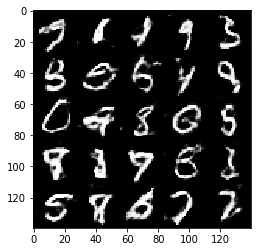

Epoch 3610/1... Discriminator Loss: 1.2602... Generator Loss: 0.7772
Epoch 3620/1... Discriminator Loss: 1.2536... Generator Loss: 1.1104
Epoch 3630/1... Discriminator Loss: 1.0881... Generator Loss: 0.8417
Epoch 3640/1... Discriminator Loss: 1.1915... Generator Loss: 1.1356
Epoch 3650/1... Discriminator Loss: 1.8786... Generator Loss: 0.4465
Epoch 3660/1... Discriminator Loss: 1.5036... Generator Loss: 0.5505
Epoch 3670/1... Discriminator Loss: 1.0504... Generator Loss: 1.1307
Epoch 3680/1... Discriminator Loss: 1.0112... Generator Loss: 1.0129
Epoch 3690/1... Discriminator Loss: 1.2342... Generator Loss: 1.4661
Epoch 3700/1... Discriminator Loss: 1.2217... Generator Loss: 0.8445


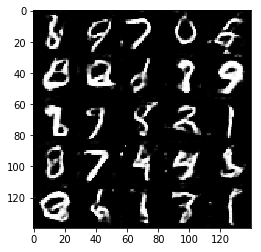

Epoch 3710/1... Discriminator Loss: 1.1314... Generator Loss: 1.3588
Epoch 3720/1... Discriminator Loss: 0.9219... Generator Loss: 1.1258
Epoch 3730/1... Discriminator Loss: 0.9215... Generator Loss: 1.3870
Epoch 3740/1... Discriminator Loss: 1.7586... Generator Loss: 0.6434
Epoch 3750/1... Discriminator Loss: 0.9057... Generator Loss: 1.2179


In [12]:
batch_size =32 #None
z_dim =128 #None
learning_rate =0.001 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

In [ ]:
batch_size = 16#None
z_dim =128 #None
learning_rate =0.001 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。